<a href="https://colab.research.google.com/github/StillWork/AIDD-LAIDD/blob/main/z9_GAN_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN 이해

- Generative Adversarial Network
- Generator와 Discriminator가 경쟁적으로 학습하면서 서로 성능을 개선하는 것


- GAN 개념 

 <img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202022-11-20%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%2011.42.33.png?raw=1" width="600" align="left">. 

- GAN의 최종 목적은 새로운 데이터를 생성하는 것임
- 응용
 - 예술품 창작(CAN)
 - 일부 지워진 이미지 복원(Image completion)

- 스타일 트랜스퍼(cycleGAN)
 
<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202022-11-27%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%2011.13.26.png?raw=1" width=700>

- 고품질의 이미지 생성(BigGAN)
- 흑백 사진에 컬러채색
 
<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202022-11-27%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%2011.13.05.png?raw=1" width=600>

- 잠재공간 (latent space) 연산으로 새로운 이미지 생성

<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202022-11-27%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%2011.15.15.png?raw=1" width=700>


## 예제

- GAN을 이용하여 MNIST 이미지 생성 예시
- Wasserstein GAN 사용
- 참고 [GAN 개념 소개](https://towardsdatascience.com/fundamentals-of-generative-adversarial-networks-b7ca8c34f0bc)

# Import

In [1]:
!pip install deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 608 kB 20.5 MB/s 
     |████████████████████████████████| 29.1 MB 26.9 MB/s 


In [2]:
import numpy as np
import deepchem as dc
import tensorflow as tf
from deepchem.models.optimizers import ExponentialDecay
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## MNIST 이미지 데이터

In [3]:
mnist = tf.keras.datasets.mnist.load_data(path='mnist.npz')

11490434/11490434 [==============================] - 2s 0us/step


In [4]:
mnist[0][0].shape

(60000, 28, 28)

## 데이터 변환
- 스케일링
- 4차원 어레이로 재구성
- ndarray에서 dataset 구성

In [5]:
images = mnist[0][0].reshape((-1, 28, 28, 1))/255
dataset = dc.data.NumpyDataset(images)
dataset

<NumpyDataset X.shape: (60000, 28, 28, 1), y.shape: (60000, 1), w.shape: (60000, 1), task_names: [0]>

- 샘플 이미지 보기


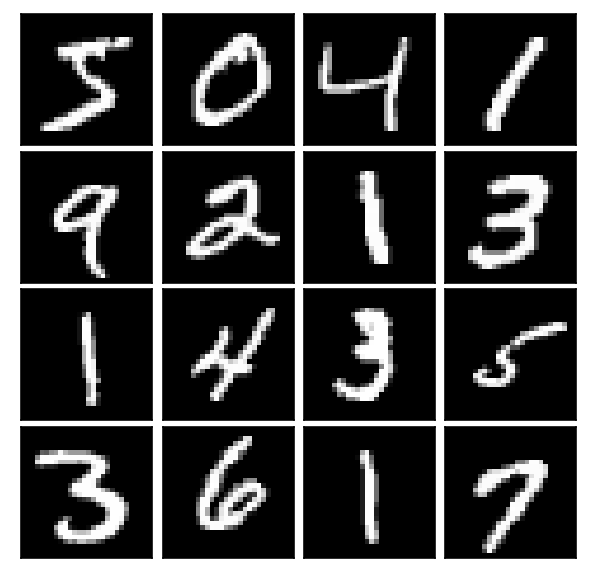

In [8]:
def plot_digits(im):
  plt.figure(figsize=(5, 5))
  grid = gridspec.GridSpec(4, 4, wspace=0.05, hspace=0.05)
  for i, g in enumerate(grid):
    ax = plt.subplot(g)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(im[i,:,:,0], cmap='gray')

plot_digits(images[:16])

# GAN 구현

- GAN은 다음과 같이 두개의 코드로 구성된다

- 생성자
 - 랜덤 신호를 입력으로 받고, 훈련 데이터에 있는 MNIST를 닮은 출력을 생성한다
- 판별자 
 - 생성자가 만든 (가짜) 출력 이미지와 (실제) 훈련 이미지를 입력으로 받아 가짜 이미지와 실제 이미지를 구분하는 작업을 수행한다

- Wasserstein GAN (WGAN)을 사용
- 생성자는 Dense망을 사용하여 입력 노이지를 7x7 크기의 이미지로 바꾸며 8개의 채널을 사용한다
 - 두 번의 컨볼류션 계층을 수행하며 각각 업샘플링을 하여 14x14 그리고 28x28 크기의 이미지로 변형한다
 
- 판별자는 위의 작업의 역순의 작업을 수행한다
 - 두 번의 컨볼류션 계층을 수행하며 각각 1/2 다운 샘플링을 하여 14x14 그리고 7x7 크기의 피처맵을 만든다
 - 이후 전결합망(dense)을 통과하여 단일값을 갖는 출력을 생성한다
- WGAN에서는 softmax 대신 softplus 활성함수를 사용하여 (0~1) 사이의 값이 아닌, 임의의 크기를 갖는 값을 출력한다
 - (분류) 확률을 얻는 것이 아니라 거리(distance)를 예측한다 
 - WGAN에서는 실제 이미지일 확률을 예측하는 것이 아니라, 훈련 이미지의 분포와 생성 이미지의 분포 사이의 "거리"를 나타낸다
 - 이 거리 값을 생성자를 훈련시키는데 손실함수로 사용하여 학습 속도를 개선했다

## GAN 클래스 정의

In [9]:
class DigitGAN(dc.models.WGAN):

  def get_noise_input_shape(self):
    return (10,)

  def get_data_input_shapes(self):
    return [(28, 28, 1)]

  def create_generator(self):
    return tf.keras.Sequential([
        Dense(7*7*8, activation=tf.nn.relu),
        Reshape((7, 7, 8)),
        Conv2DTranspose(filters=16, kernel_size=5, strides=2, activation=tf.nn.relu, padding='same'),
        Conv2DTranspose(filters=1, kernel_size=5, strides=2, activation=tf.sigmoid, padding='same')
    ])

  # softplus 사용
  def create_discriminator(self):
    return tf.keras.Sequential([
        Conv2D(filters=32, kernel_size=5, strides=2, activation=tf.nn.leaky_relu, padding='same'),
        Conv2D(filters=64, kernel_size=5, strides=2, activation=tf.nn.leaky_relu, padding='same'),
        Dense(1, activation=tf.math.softplus)
    ])

gan = DigitGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000), model_dir = 'gan')

# 모델 학습

- 이미지 생성자는 dataset에서 데이터를 가지고 오며 epoch는 100으로 설정했다

- 일반적인 GAN을 구현할 때는 생성자와 판별자를 훈련시키는데 서로 너무 큰 실력 차이가 나지 않도록 세심하게 주의를 해야 한다
- 실력(성능)의 차이가 너무 크면 균형있게 두개의 모델을 학습시키기가 어렵기 때문이다

- WGAN에서는 이러한 문제를 피할 수 있는데, 판별자의 성능이 좋아지면 이에 비례한 손실함수(거리)를 알려주고 이를 통해 생성자가 학습을 더 잘 할 수 있게 한다
- `generator_steps=0.2`로 설정하였다. 이는 판별자가 5회 학습하면 생성자가 1회 학습하는 비율인데, 이렇게 하여 학습 속도를 높이고 더 나은 성능을 얻도록 한다

## softmax와 softplus

(-0.1, 3.0)

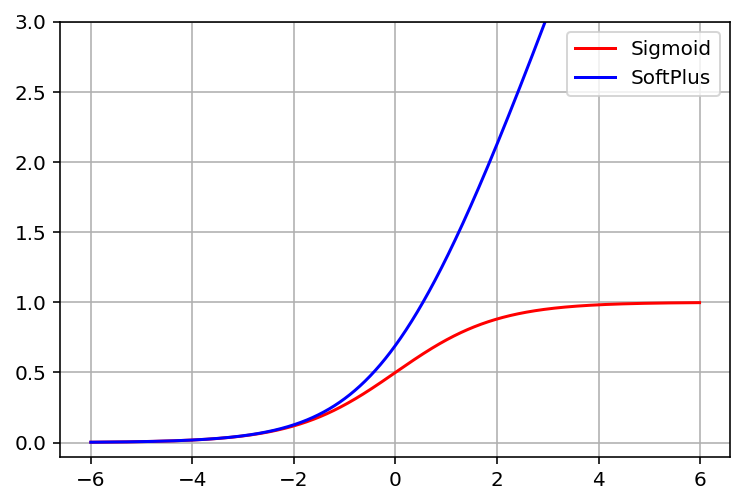

In [10]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

x = np.arange(-6, 6, 0.01)

def sigmoid(x): # 시그모이드(Sigmoid, S-커브), Logistic Regression
    return 1 / (1 + np.exp(-x)) 
ax.plot(x, sigmoid(x), color='r', linestyle='-', label="Sigmoid")

def softplus_func(x): # SoftPlus 함수
    return np.log( 1 + np.exp(x) )
ax.plot(x, softplus_func(x), color='b', linestyle='-', label="SoftPlus")

ax.grid()
ax.legend()
plt.ylim(-0.1, 3)

## 데이터 읽기

- 배치단위로 읽는다
- iterbatches() 함수 사용

In [11]:
def iterbatches(epochs):
  for i in range(epochs):
    for batch in dataset.iterbatches(batch_size=gan.batch_size):
      yield {gan.data_inputs[0]: batch[0]}

In [12]:
gan.fit_gan(iterbatches(100), generator_steps=0.2, checkpoint_interval=5000)

KeyboardInterrupt: ignored

## 백업된 모델 사용하기
- 구글 드라이브에 모델을 백업한 경우

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
gan = DigitGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000), 
               model_dir = '/content/drive/MyDrive/gan')
gan.restore()

## 이미지 생성 결과 보기

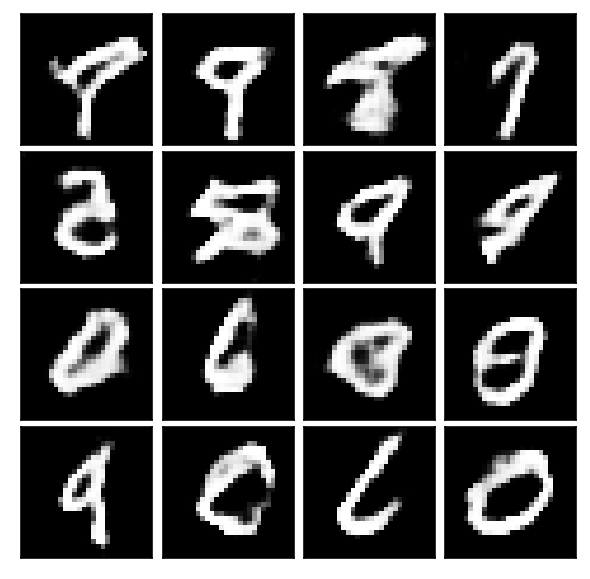

In [15]:
plot_digits(gan.predict_gan_generator(batch_size=100))